In [ ]:
########################################################################################################################
# Filename: FF_Models_Training.ipynb
#
# Purpose: Multi-label Text-categorization via feed forward neural networks -- Train networks/generate results

# Author(s): Bobby (Robert) Lumpkin
#
# Library Dependencies: numpy, pandas, scikit-learn, skmultilearn, joblib, os, sys, threshold_learning, matplotlib
########################################################################################################################

# Multilabel Text Classification with Feed Forward Networks

In [4]:
import numpy as np
import pandas as pd
import math
import os
import json
import ast
import random
from joblib import dump, load
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from bpmll import bp_mll_loss
import sklearn_json as skljson
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import sys
os.chdir('C:\\Users\\rober\\OneDrive\\Documents\\Multilabel-Text-Classification\\Deep Learning Models\\FF Models')  ## Set working directory
                                                                                                                      ## to be 'ANN Results'
sys.path.append('../../ThresholdFunctionLearning')    ## Append path to the ThresholdFunctionLearning directory to the interpreters
                                                   ## search path
from threshold_learning import predict_test_labels_binary    ## Import the 'predict_test_labels_binary()' function from the 
from threshold_learning import predict_labels_binary         ## threshold_learning library
sys.path.append('GridSearchAid_FFNetworks')
from FFNN_gridSearch_aid import SizeLayersPows2, createModel

In [5]:
## Load the seperabe PCs training and test data
npzfile = np.load("../../Data/tfidf_PC_separable.npz")
X_sepPCs_train = npzfile['X_sepPCs_train']
X_sepPCs_test = npzfile['X_sepPCs_test']
Y_train = npzfile['Y_train'].astype('float64')
Y_test = npzfile['Y_test'].astype('float64')

## Load the autoencoder train/test features
npzfile = np.load('../../Data/tfidf_encoded_data.npz')
encoded_train = npzfile['encoded_train']
encoded_test = npzfile['encoded_test']

## Load the tfidf training and test data
npzfile = np.load("../../Data/tfidf_trainTest_data.npz", allow_pickle = True)
X_tfidfTrain = npzfile['X_tfidfTrain']
X_tfidfTest = npzfile['X_tfidfTest']

# Cross Entropy Models -- Traditional ("Naive") Approach


## Training on Dimension-Reduced Separable PC Vectors

In [6]:
%%capture
## (CAUTION: THIS TAKES A WHILE TO RUN. INSTEAD, USE NEXT CELL TO DEFINE MODELS AND READ IN TRAINED PARAMETERS)
## (NOTE: The 7 layer model was too large to store on GitHub -- You can adjust the code in this cell to 
## define & train only the 7-layer network)
## Perform small grid search to choose number of layers
model_dict = {}
history_dict = {}
for num_layers in [3, 5, 7]:
    model = createModel(X_sepPCs_train, 
                        num_layers, 
                        X_sepPCs_train.shape[0], 
                        Y_train.shape[1], 
                        activation_func = 'relu', 
                        output_activation = 'sigmoid', 
                        loss_func = 'binary_crossentropy')
    
    tf.random.set_seed(123)
    model_history = model.fit(X_sepPCs_train, Y_train, epochs = 30,
                              validation_data = (X_sepPCs_test, Y_test), verbose = 0)
    name = f"model_{num_layers}_sepPCs_ce"
    model_dict[name] = model
    history_dict[name] = model_history
    
## Convert the training histories to DFs for plotting
history_3 = history_dict['model_3_sepPCs_ce']
history_5 = history_dict['model_5_sepPCs_ce']
history_7 = history_dict['model_7_sepPCs_ce']
history_3DF = pd.DataFrame(history_3.history)
history_5DF = pd.DataFrame(history_5.history)
history_7DF = pd.DataFrame(history_7.history)

model_3_sepPCs_ce = model_dict['model_3_sepPCs_ce']
model_5_sepPCs_ce = model_dict['model_5_sepPCs_ce']
model_7_sepPCs_ce = model_dict['model_7_sepPCs_ce']

In [29]:
%%capture
## (NOTE: IF RUNNING PREVIOUS CELL, SKIP THIS CELL) -- Load models and training histories
model_dict = {}
for num_layers in [3, 5, 7]:
    model = createModel(X_sepPCs_train, 
                        num_layers, 
                        X_sepPCs_train.shape[0], 
                        Y_train.shape[1], 
                        activation_func = 'relu', 
                        output_activation = 'sigmoid', 
                        loss_func = 'binary_crossentropy')
    
    name = f"model_{num_layers}_sepPCs_ce"
    model_dict[name] = model

model_3_sepPCs_ce = model_dict['model_3_sepPCs_ce']
model_5_sepPCs_ce = model_dict['model_5_sepPCs_ce']
model_7_sepPCs_ce = model_dict['model_7_sepPCs_ce']
model_3_sepPCs_ce.load_weights('Models sepPCs/FFNN_3layers_ce')
model_5_sepPCs_ce.load_weights('Models sepPCs/FFNN_5layers_ce')
model_7_sepPCs_ce.load_weights('Models sepPCs/FFNN_7layers_ce')

preds_3 = model_3_sepPCs_ce.predict(X_sepPCs_test)
preds_5 = model_5_sepPCs_ce.predict(X_sepPCs_test)
preds_7 = model_7_sepPCs_ce.predict(X_sepPCs_test)

histories = np.load("Training Histories Layers GS/history_ce_FF_sepPCs_lr001.npz", allow_pickle = True)
history_cols = ['loss', 'hamming_loss', 'val_loss', 'val_hamming_loss']
history_3DF = pd.DataFrame(histories['history_3DF'], columns = history_cols)
history_5DF = pd.DataFrame(histories['history_5DF'], columns = history_cols)
history_7DF = pd.DataFrame(histories['history_7DF'], columns = history_cols)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 1024)              34816     
_________________________________________________________________
dense_13 (Dense)             (None, 90)                92250     
Total params: 127,066
Trainable params: 127,066
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 2048)              69632     
_________________________________________________________________
dense_15 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_16 (Dense)             (None, 256)               262400    
__________________________

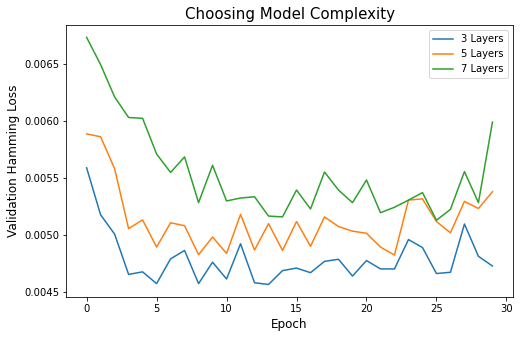

In [7]:
## Visualize the 'val_hamming_loss' histories for each model in a single plot
plt.figure(figsize=(8, 5))
plt.plot(history_3DF['val_hamming_loss'], label = '3 Layers')
plt.plot(history_5DF['val_hamming_loss'], label = '5 Layers')
plt.plot(history_7DF['val_hamming_loss'], label = '7 Layers')
plt.xlabel('Epoch', fontsize = 12)
plt.ylabel('Validation Hamming Loss', fontsize = 12)
plt.legend()
plt.title('Choosing Model Complexity', fontsize = 15)
#plt.savefig('Reduced_Dataset_Learning_Rate_01.png')

## Print the model summaries
model_3_sepPCs_ce.summary()
model_5_sepPCs_ce.summary()
model_7_sepPCs_ce.summary()

In [14]:
## (CAUTION: DO NOT OVERWRITE EXISTING FILES) -- Convert training history to dataframe and write to a .json file 
outfile = "Training Histories Layers GS/history_ce_FF_sepPCs_lr001.npz" 
#np.savez_compressed(outfile, history_3DF = history_3DF,
#                             history_5DF = history_5DF,
#                             history_7DF = history_7DF)

#model_3_sepPCs_ce.save_weights('Models sepPCs/FFNN_3layers_ce')
#model_5_sepPCs_ce.save_weights('Models sepPCs/FFNN_5layers_ce')
#model_7_sepPCs_ce.save_weights('Models sepPCs/FFNN_7layers_ce')

## Training on Dimension-Reduced Autoencoder Feature Vectors

In [8]:
%%capture
## (CAUTION: THIS TAKES A WHILE TO RUN. INSTEAD, USE NEXT CELL TO DEFINE MODELS AND READ IN TRAINED PARAMETERS)
## (NOTE: The 7 layer model was too large to store on GitHub -- You can adjust the code in this cell to 
## define & train only the 7-layer network)
## Perform small grid search to choose number of layers
model_dict = {}
history_dict = {}
for num_layers in [3, 5, 7]:
    model = createModel(encoded_train, 
                        num_layers, 
                        encoded_train.shape[0], 
                        Y_train.shape[1], 
                        activation_func = 'relu', 
                        output_activation = 'sigmoid', 
                        loss_func = 'binary_crossentropy')
    
    tf.random.set_seed(123)
    model_history = model.fit(encoded_train, Y_train, epochs = 30,
                              validation_data = (encoded_test, Y_test), verbose = 0)
    name = f"model_{num_layers}_encoded_ce"
    model_dict[name] = model
    history_dict[name] = model_history
    
## Convert the training histories to DFs for plotting
history_3 = history_dict['model_3_encoded_ce']
history_5 = history_dict['model_5_encoded_ce']
history_7 = history_dict['model_7_encoded_ce']
history_3DF = pd.DataFrame(history_3.history)
history_5DF = pd.DataFrame(history_5.history)
history_7DF = pd.DataFrame(history_7.history)

model_3_encoded_ce = model_dict['model_3_encoded_ce']
model_5_encoded_ce = model_dict['model_5_encoded_ce']
model_7_encoded_ce = model_dict['model_7_encoded_ce']

In [27]:
%%capture
## (NOTE: IF RUNNING PREVIOUS CELL, SKIP THIS CELL) -- Load models and training histories
model_dict = {}
for num_layers in [3, 5, 7]:
    model = createModel(encoded_train, 
                        num_layers, 
                        encoded_train.shape[0], 
                        Y_train.shape[1], 
                        activation_func = 'relu', 
                        output_activation = 'sigmoid', 
                        loss_func = 'binary_crossentropy')
    
    name = f"model_{num_layers}_encoded_ce"
    model_dict[name] = model

model_3_encoded_ce = model_dict['model_3_encoded_ce']
model_5_encoded_ce = model_dict['model_5_encoded_ce']
model_7_encoded_ce = model_dict['model_7_encoded_ce']
model_3_encoded_ce.load_weights('Models encoded/FFNN_3layers_ce')
model_5_encoded_ce.load_weights('Models encoded/FFNN_5layers_ce')
model_7_encoded_ce.load_weights('Models encoded/FFNN_7layers_ce')

preds_3 = model_3_encoded_ce.predict(encoded_test)
preds_5 = model_5_encoded_ce.predict(encoded_test)
preds_7 = model_7_encoded_ce.predict(encoded_test)

histories = np.load("Training Histories Layers GS/history_ce_FF_encoded_lr001.npz", allow_pickle = True)
history_cols = ['loss', 'hamming_loss', 'val_loss', 'val_hamming_loss']
history_3DF = pd.DataFrame(histories['history_3DF'], columns = history_cols)
history_5DF = pd.DataFrame(histories['history_5DF'], columns = history_cols)
history_7DF = pd.DataFrame(histories['history_7DF'], columns = history_cols)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 1024)              34816     
_________________________________________________________________
dense_25 (Dense)             (None, 90)                92250     
Total params: 127,066
Trainable params: 127,066
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 2048)              69632     
_________________________________________________________________
dense_27 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_28 (Dense)             (None, 256)               262400    
__________________________

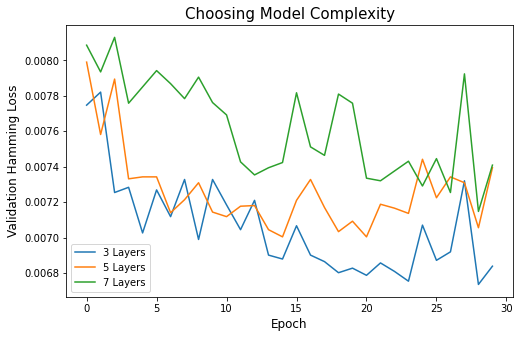

In [9]:
## Visualize the 'val_hamming_loss' histories for each model in a single plot
plt.figure(figsize=(8, 5))
plt.plot(history_3DF['val_hamming_loss'], label = '3 Layers')
plt.plot(history_5DF['val_hamming_loss'], label = '5 Layers')
plt.plot(history_7DF['val_hamming_loss'], label = '7 Layers')
plt.xlabel('Epoch', fontsize = 12)
plt.ylabel('Validation Hamming Loss', fontsize = 12)
plt.legend()
plt.title('Choosing Model Complexity', fontsize = 15)
#plt.savefig('Reduced_Dataset_Learning_Rate_01.png')

## Print the model summaries
model_3_encoded_ce.summary()
model_5_encoded_ce.summary()
model_7_encoded_ce.summary()

In [22]:
## (CAUTION: DO NOT OVERWRITE EXISTING FILES) -- Convert training history to dataframe and write to a .json file 
outfile = "Training Histories Layers GS/history_ce_FF_encoded_lr001.npz" 
#np.savez_compressed(outfile, history_3DF = history_3DF,
#                             history_5DF = history_5DF,
#                             history_7DF = history_7DF)

#model_3_encoded_ce.save_weights('Models encoded/FFNN_3layers_ce')
#model_5_encoded_ce.save_weights('Models encoded/FFNN_5layers_ce')
#model_7_encoded_ce.save_weights('Models encoded/FFNN_7layers_ce')

# BPMLL Models -- "Novel" Approach

## Training on Dimension-Reduced Separable PC Vectors

In [46]:
## Perform small grid search to choose number of layers
model_dict = {}
history_dict = {}
for num_layers in [3, 4, 5]:
    model = createModel(X_sepPCs_train, 
                        num_layers, 
                        X_sepPCs_train.shape[0], 
                        Y_train.shape[1], 
                        activation_func = 'relu', 
                        output_activation = 'sigmoid', 
                        loss_func = bp_mll_loss)
    
    tf.random.set_seed(123)
    model_history = model.fit(X_sepPCs_train, Y_train, epochs = 30,
                              validation_data = (X_sepPCs_test, Y_test), verbose = 0)
    name = f"{num_layers}_layers"
    model_dict[name] = model
    history_dict[name] = model_history

KeyboardInterrupt: 